In [54]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score
from sklearn.cluster import KMeans
import time

In [55]:
def coreset(data, m):
    N = data.shape[0]
    
    mean = np.mean(data, axis=0)
    
    q = np.linalg.norm(data - mean, axis=1)**2
    sum = np.sum(q)
    q = 0.5 * (1.0/N + q/sum)
    
    samples = np.random.choice(N, m, p=q)
    coreset = data[samples]
    weights = 1.0 / (q[samples] * m)
    
    return coreset, weights 

In [56]:
def kmeans_cost(data, centers, labels):
    cost = 0.0
    for i in range(len(data)):
        distance = np.linalg.norm(data[i] - centers[labels[i]]) ** 2
        cost += distance
    return cost

In [70]:
def kmedoids_cost(data, centroids, labels):
    dist = cdist(data, centroids, 'cityblock')
    total_cost = np.sum(dist[np.arange(len(data)), labels])
    return total_cost

In [68]:
traindata = pd.DataFrame(pd.read_csv("bio_train.dat", sep="\t", header=None))
traindata = traindata.dropna()
traindata = traindata.drop_duplicates()
traindata = traindata[:10000]

In [81]:
np.random.seed(42)

In [69]:
def kmediod(data, weights, k, max_iterations=500):
    data = np.asarray(data)
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    centroids = np.random.rand(k, data.shape[1]) * (maxs - mins) + mins
    
    for _ in range(max_iterations):
        dist = cdist(data, centroids, 'cityblock')
        weighted_dist = dist * weights[:, np.newaxis]
        labels = np.argmin(weighted_dist, axis=1)
        
        for j in range(k):
            cluster = labels == j
            if weights[cluster].sum() > 0:
                centroids[j] = np.average(data[cluster], axis=0, weights=weights[cluster])
            else:
                centroids[j] = np.random.rand(1, data.shape[1]) * (maxs - mins) + mins
    
    return centroids

def predict(data, centroids):
    dist = cdist(data, centroids, 'cityblock')
    labels = np.argmin(dist, axis=1)
    return labels

In [91]:
def get_results(coreset_size, n_clusters, X, data_name):
    centers = kmediod(X, np.ones(X.shape[0]), n_clusters)
    optimal_labels = predict(X, centers)
    cost = kmedoids_cost(X, centers, optimal_labels)
    results = []
    for ssize in coreset_size:
        avg_cost = 0
        start_time = time.time()
        rand_index = 0.0
        for _ in range(5):
            X_sample, weight = coreset(X, ssize)
            kmeans = kmediod(X_sample, weight, n_clusters)
            labels = predict(X, kmeans)
            avg_cost += kmedoids_cost(X, kmeans, labels)
            rand_index += rand_score(optimal_labels, labels)
        rand_index /= 5
        end_time = time.time()
        avg_cost /= 5
        reduction = ((X.shape[0] - X_sample.shape[0])/X.shape[0])*100
        error = (abs(avg_cost - cost)/cost)*100
        results.append({'Sampling Type': 'Lightweight Coresets',
                            'Coreset Size': X_sample.shape[0],
                            'Average Cost': avg_cost,
                            'Reduction in Data Size': reduction,
                            'Error': error,
                            'Avg Rand Index': rand_index,
                            'Data': data_name,
                            'Optimal Cost': cost,
                            'Avg Time': (end_time - start_time)/5,
                            'Clustering Algorithm': 'KMedoids'})
    return results

In [92]:
mat_data = scipy.io.loadmat('olivettifaces.mat')
traindata = mat_data['faces'].T
traindata = pd.DataFrame(traindata)
traindata.dropna()
traindata.drop_duplicates()
traindata.shape

(400, 4096)

In [93]:
centers = kmediod(traindata.values, np.ones(traindata.shape[0]), 50)
labels = predict(traindata.values, centers)
cost = kmedoids_cost(traindata.values, centers, labels)
print(f'Optimal Cost: {cost}')

Optimal Cost: 28280090.101426713


In [96]:
results = get_results([10, 20, 50, 70, 100], 10, traindata.values, data_name='Face')

In [97]:
results

[{'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 10,
  'Average Cost': 44466623.480324544,
  'Reduction in Data Size': 97.5,
  'Error': 32.706231948138935,
  'Avg Rand Index': 0.7236315789473683,
  'Data': 'Face',
  'Optimal Cost': 33507562.401215583,
  'Avg Time': 0.3841738224029541,
  'Clustering Algorithm': 'KMedoids'},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 20,
  'Average Cost': 40296261.73404654,
  'Reduction in Data Size': 95.0,
  'Error': 20.260200522926368,
  'Avg Rand Index': 0.7109298245614035,
  'Data': 'Face',
  'Optimal Cost': 33507562.401215583,
  'Avg Time': 0.7206645965576172,
  'Clustering Algorithm': 'KMedoids'},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 50,
  'Average Cost': 36225223.728851005,
  'Reduction in Data Size': 87.5,
  'Error': 8.110590961808763,
  'Avg Rand Index': 0.809310776942356,
  'Data': 'Face',
  'Optimal Cost': 33507562.401215583,
  'Avg Time': 1.0982349872589112,
  'Clustering Algorithm': 'KMed

In [98]:
df = pd.read_csv('results.csv')
df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
df.to_csv('results.csv', index=False)

In [87]:
df.to_csv('results.csv', index=False)

In [88]:
import torch
from torchvision import datasets, transforms
import numpy as np

In [89]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_test = test_dataset.targets.numpy()

In [90]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [45]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42).fit(X_train)
centers = kmeans.cluster_centers_
optimal_labels = kmeans.labels_
cost = kmeans_cost(X_train, centers, kmeans.labels_)
print(f'Cost of KMeans: {cost}')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cost of KMeans: 1906652.134114885


In [47]:
results = get_results([100, 500, 1000, 1500, 3500, 5000, 7000, 10000, 20000], 10, X_train, optimal_labels, cost, 'FMNIST')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [48]:
results

[{'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 100,
  'Average Cost': 2158636.326811089,
  'Reduction in Data Size': 99.83333333333333,
  'Error': 13.216054894732093,
  'Avg Rand Index': 0.9262602944493519,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.7076163768768311},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 500,
  'Average Cost': 1964584.322251501,
  'Reduction in Data Size': 99.16666666666667,
  'Error': 3.038424634471121,
  'Avg Rand Index': 0.9439008477919076,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.8357719898223877},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 1000,
  'Average Cost': 1952921.3907622057,
  'Reduction in Data Size': 98.33333333333333,
  'Error': 2.4267277611602722,
  'Avg Rand Index': 0.9322383896398273,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.8374724388122559},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size':

In [50]:
df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
df

,Sampling Type,Coreset Size,Average Cost,Reduction in Data Size,Error,Avg Rand Index,Data,Optimal Cost,Avg Time,Num Iterations Volume Sampling
0,Volume Sampling,474,1.150492e+11,95.260000,463.848772,0.963519,KDD,2.040426e+10,0.211612,1.0
1,Volume Sampling,475,1.326848e+11,95.250000,550.279722,0.966513,KDD,2.040426e+10,0.221085,2.0
2,Volume Sampling,478,1.755777e+11,95.220000,760.495267,0.953055,KDD,2.040426e+10,0.255715,5.0
3,Volume Sampling,926,5.792439e+10,90.740000,183.883834,0.972418,KDD,2.040426e+10,0.265303,1.0
4,Volume Sampling,906,8.645982e+10,90.940000,323.734209,0.966581,KDD,2.040426e+10,0.298187,2.0
...,...,...,...,...,...,...,...,...,...,...
62,Lightweight Coresets,3500,1.919632e+06,94.166667,0.680786,0.964250,FMNIST,1.906652e+06,1.470711,NaN
63,Lightweight Coresets,5000,1.914712e+06,91.666667,0.422711,0.981262,FMNIST,1.906652e+06,2.005592,NaN
64,Lightweight Coresets,7000,1.916026e+06,88.333333,0.491659,0.972177,FMNIST,1.906652e+06,2.750548,NaN
65,Lightweight Coresets,10000,1.912398e+06,83.333333,0.301370,0.979475,FMNIST,1.906652e+06,6.492139,NaN


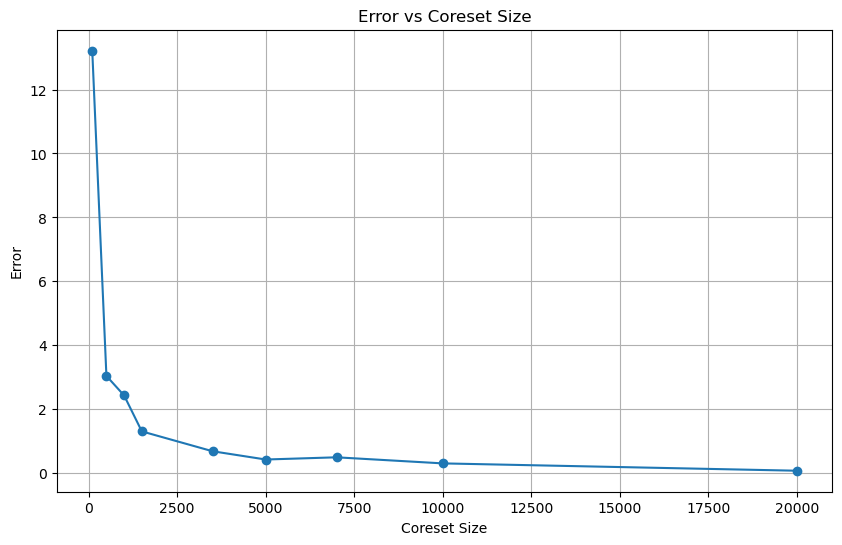

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(df[df['Data'] == 'FMNIST']['Coreset Size'], df[df['Data'] == 'FMNIST']['Error'], marker='o')
plt.xlabel('Coreset Size')
plt.ylabel('Error')
plt.title('Error vs Coreset Size')
plt.grid()
plt.show()

In [52]:
df.to_csv('results.csv', index=False)

In [58]:
import scipy.io

mat_data = scipy.io.loadmat('olivettifaces.mat')
traindata = mat_data['faces'].T
traindata = pd.DataFrame(traindata)
traindata.dropna()
traindata.drop_duplicates()
traindata.shape

(400, 4096)

In [59]:
kmeans = KMeans(n_clusters=10, init="k-means++", random_state=42).fit(traindata)
optimal_labels = kmeans.labels_
centers = kmeans.cluster_centers_
cost = kmeans_cost(traindata.values, centers, optimal_labels)
print(f'Cost of KMeans: {cost}')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of

Cost of KMeans: 1113896034.8289247


In [60]:
results = get_results([10, 20, 50, 70, 100], 10, traindata.values, optimal_labels, cost, 'Olivetti')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [61]:
results

[{'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 10,
  'Average Cost': 2009795555.9519997,
  'Reduction in Data Size': 97.5,
  'Error': 80.42936621645033,
  'Avg Rand Index': 0.7994461152882205,
  'Data': 'Olivetti',
  'Optimal Cost': 1113896034.8289247,
  'Avg Time': 0.2757021427154541},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 20,
  'Average Cost': 1605441026.7355871,
  'Reduction in Data Size': 95.0,
  'Error': 44.12844435541557,
  'Avg Rand Index': 0.7668822055137845,
  'Data': 'Olivetti',
  'Optimal Cost': 1113896034.8289247,
  'Avg Time': 0.083245849609375},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 50,
  'Average Cost': 1357196663.4430695,
  'Reduction in Data Size': 87.5,
  'Error': 21.842310324007176,
  'Avg Rand Index': 0.8426967418546365,
  'Data': 'Olivetti',
  'Optimal Cost': 1113896034.8289247,
  'Avg Time': 0.07857561111450195},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 70,
  'Average Cost': 1292995382

In [62]:
df = pd.read_csv('results.csv')
df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
df.to_csv('results.csv', index=False)